## Building the model



Our model needs to take molecular structure information as input and predict the energy based on this information.

In [ ]:
# import necessary libraries
!pip install ase
from ase.io import read
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

     |████████████████████████████████| 2.2 MB 8.5 MB/s 


In [ ]:
file_path="/content/H2O_rotated.xyz"

ftrs=read(file_path,':')
nsample=len(ftrs)                                                   
natom=[ftrs[i].get_number_of_atoms() for i in range(nsample)]
coords=np.array([ftrs[i].get_positions() for i in range(nsample)])
all_labels=[ftrs[i].get_chemical_symbols() for i in range(nsample)]

print(coords)

# read the corresponding energy values
ener=np.loadtxt("/content/H2O_rotated.ener")

[[[ 5.60235675  5.79886541  4.67581523]
  [ 5.54724273  5.60928103  5.66644264]
  [ 5.12313088  4.80146879  5.79739866]]

 [[ 1.59175857  1.33176143  1.83369687]
  [ 1.21085904  1.52442989  1.06483624]
  [ 0.73271895  0.6999796   0.72043491]]

 [[ 7.11503125  7.5612348   6.46322794]
  [ 7.11158147  7.23446307  7.39583841]
  [ 7.00580296  6.32617946  7.34159254]]

 ...

 [[10.02314832  9.20127772 10.25619487]
  [10.18540106  9.92449149  9.67854711]
  [ 9.53368568 10.58209647  9.83261783]]

 [[-1.73824062 -2.72437786 -1.81815978]
  [-1.75859305 -1.76705274 -2.1137744 ]
  [-2.64282209 -1.59810476 -2.08302767]]

 [[ 7.3046148   8.31213486  7.69501413]
  [ 7.51002488  7.51086283  7.2619984 ]
  [ 8.16772101  7.06663963  7.90037513]]]


/usr/local/lib/python3.7/dist-packages/ase/atoms.py:968: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  np.VisibleDeprecationWarning)


For neural network, as the method is numerical, we should normalize our input and output for better accuracy.
$$
x_i'=\frac{x_i - \bar{x}}{x_{max} - x_{min}}
$$

In [ ]:
seperations = np.zeros((len(coords),3))

for i, x in enumerate(coords):
  seperations[i][0] = np.linalg.norm(x[0] - x[1])
  seperations[i][1] = np.linalg.norm(x[2]-x[1])
  seperations[i][2] = np.linalg.norm(x[2]-x[0])

#normalize inputs
norm_seps=np.zeros((seperations.shape))
for j in range(3):
  norm_seps[:,j] = (seperations[:,j] - np.mean(seperations[:,j]))/(np.max(seperations[:,j]) - np.min(seperations[:,j]))

#normalize outputs
norm_E = (ener - np.mean(ener))/(np.max(ener) - np.min(ener))

First, we build a model with customizable parameters to make our codes short and neat. There are 2 basic ways to build a model in Keras, through the Sequential API and Functional API. Sequential models are straightforward and easy to create by building it layer by layer, but are not flexible (not allowing multiple inputs and outputs, no layer sharings, etc.) On the other hand, the Functional API is more flexible and powerful, allowing different customizations. In this tutorial, for the sake of simplicity, we will use the Sequential API and the `add()` method.

You can test if the model architecture is as desired. In the table of this output, the layers are listed from input, hidden layers, and lastly, output layer. Each layer has its own output shape and the number of parameters that will be learned during the training process. The total number of parameters, trainable parameters, and non-trainable parameters are printed below the table.

In [ ]:
# build and compile the model
def build_compile_model(reg, learn_rate):
    model = keras.Sequential()
    #specify an input layer with the number of nodes = the number of relative distances
    model.add(layers.Input(shape=(x.shape[1])))

    #flatten the 2D input array into a 1D array, you can also do this with numpy .flatten()
    #model.add(layers.Flatten(input_shape=(natom,3)))

    #add hidden layers
    model.add(layers.Dense(32, activation='sigmoid', kernel_regularizer=keras.regularizers.l2(reg), bias_regularizer=keras.regularizers.l2(reg)))
    model.add(layers.Dense(16, activation='sigmoid', kernel_regularizer=keras.regularizers.l2(reg), bias_regularizer=keras.regularizers.l2(reg)))
    model.add(layers.Dense(8, activation='sigmoid', kernel_regularizer=keras.regularizers.l2(reg), bias_regularizer=keras.regularizers.l2(reg)))

    #finally, add an output layer
    model.add(layers.Dense(1, use_bias=False,kernel_regularizer=keras.regularizers.l2(reg)))

    # define the optimizer: Adam is a gradient descent algorithm 
    opt=keras.optimizers.Adam(learning_rate=learn_rate)

    #compile the model
    model.compile(loss='mse',optimizer=opt)

    return model

model = build_compile_model(1e-6, 0.001)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 32)                128       
                                                                 
 dense_9 (Dense)             (None, 16)                528       
                                                                 
 dense_10 (Dense)            (None, 8)                 136       
                                                                 
 dense_11 (Dense)            (None, 1)                 8         
                                                                 
Total params: 800
Trainable params: 800
Non-trainable params: 0
_________________________________________________________________


The model is now ready to be trained. The data set is randomly divided here into the training set (with 1250 configurations), the validation set (with 250 configurations), and the test set (with 250 configurations). The validation set will mainly be used in the later sections to optimize the hyperparameters. The test set contains configurations your model has never seen and is used to test the generalizability of the model and its RMSE.

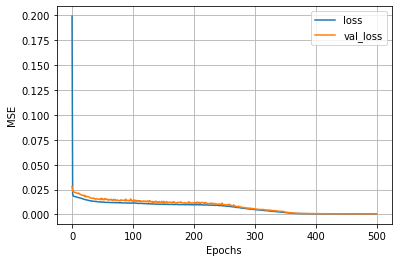

In [ ]:
idx=np.arange(nsample)
np.random.shuffle(idx)
tr_coords=norm_seps[idx[:1250],:]
tr_E=norm_E[idx[:1250]]
va_coords=norm_seps[idx[1250:1500],:]
va_E=norm_E[idx[1250:1500]]
te_coords=norm_seps[idx[1500:],:]
te_E=ener[idx[1500:]]

history=model.fit(tr_coords,tr_E,epochs=500,validation_data=(va_coords,va_E),verbose=0)

# plot a learning curve of loss of the training and validation set vs the number of epochs the model is trained
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

The model's RMSE is:  0.004869937931713722


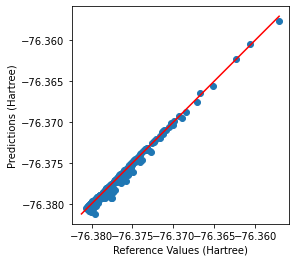

In [ ]:
norm_predict=model.predict(te_coords)
predict=norm_predict*(np.max(ener) - np.min(ener))+np.mean(ener)
rmse = np.sqrt(np.mean((predict-te_E)**2))

print("The model's RMSE is: ", rmse)
#visualize the model's prediction vs the correct value
plt.axes(aspect='equal')
plt.scatter(te_E, predict)
plt.xlabel('Reference Values (Hartree)')
plt.ylabel('Predictions (Hartree)')
plt.plot([np.min([np.min(te_E),np.min(predict)]),np.max([np.max(te_E),np.max(predict)])], [np.min([np.min(te_E),np.min(predict)]),np.max([np.max(te_E),np.max(predict)])], 'r-')
plt.show()

## Effects of hyperparameters

Hyperparameters usually affect the performance of your model significantly. Therefore, it is important to optimize them. Two hyperparameters are optimized in the following sections but (of course) there are many more that can be explored. You are encouraged to play with the values of the hyperparameters.

1. Regularization

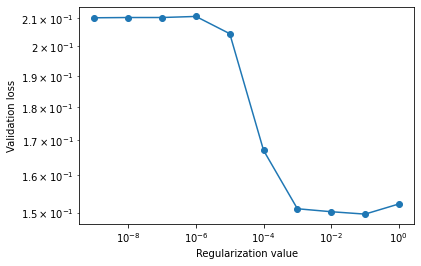

In [ ]:
regularization=[1,0.1,0.01,0.001,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9]
va_loss=[]
for r in range(len(regularization)):
  model = build_compile_model( regularization[r], 0.001)
  history = model.fit(tr_coords,tr_E,epochs=500,validation_data=(va_coords,va_E),verbose=0)
  va_predict=model.predict(va_coords)
  # get the RMSE of the model prediction for the validation set
  va_loss.append(np.sqrt(np.mean((va_predict-va_E)**2)))

#visualize the effects of different regularization values on the model's accuracy
plt.plot(regularization, va_loss, marker='o')
plt.yscale("log")
plt.xscale("log")
plt.xlabel('Regularization value')
plt.ylabel('Validation loss')
plt.show()

# get the regularization value corresponding to the smallest validation error
for i in range(len(va_loss)):
    if va_loss[i]==min(va_loss):
        reg=regularization[i]


2. Learning rate

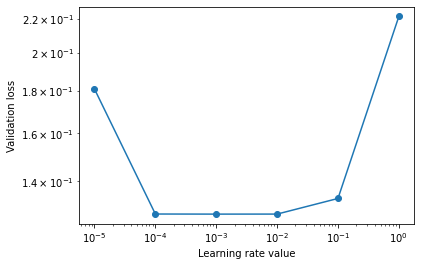

In [ ]:
learning_rate=[1,0.1,0.01,0.001,0.0001,1e-5]
va_loss=[]
for lr in range(len(learning_rate)):
  model = build_compile_model(3, reg, learning_rate[lr])
  history = model.fit(tr_coords,tr_E,epochs=500,validation_data=(va_coords,va_E),verbose=0)
  va_predict=model.predict(va_coords)
  # get the RMSE of the model prediction for the validation set
  va_loss.append(np.sqrt(np.mean((va_predict-va_E)**2)))

#visualize the effects of different learning rate values on the model's accuracy
plt.plot(learning_rate, va_loss, marker='o')
plt.yscale("log")
plt.xscale("log")
plt.xlabel('Learning rate value')
plt.ylabel('Validation loss')
plt.show()

# get the learning rate value corresponding to the smallest validation error
for i in range(len(va_loss)):
    if va_loss[i]==min(va_loss):
        learn_rate=learning_rate[i]

## Learning curve

It would be interesting to show how the model would behave if trained on a smaller or larger data set. It is a way to tell if you need to gather more data to improve the model's accuracy or if it's saturated.

In [ ]:
training_points=[1500,1250,1000,750,500,250,100,50]
te_rmse=[]
for p in range(len(training_points)):
  ntrain=training_points[p]
  tr_coords=norm_coords[idx[:ntrain],:]
  tr_E=norm_E[idx[:ntrain]]

  model.fit(tr_coords,tr_E,epochs=1000,validation_data=(va_coords,va_E),verbose=0)

  norm_predict=model.predict(te_coords)
  predict=norm_predict*(np.max(ener) - np.min(ener))+np.mean(ener)
  te_rmse.append(np.sqrt(np.mean((predict-te_E)**2)))

plt.plot(training_points, te_rmse, marker='o')
plt.xlabel('Training points')
plt.ylabel('Model RMSE (Hartree)')
plt.show()